In [153]:
import os, glob, numpy as np, csv, math
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import signal, fftpack
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


dir_path = os.path.dirname(os.path.realpath('plotter_notebook.ipynb'))
wrkdir = os.path.join(dir_path,'data')
csv_files = os.path.join(wrkdir,'*.csv')
meta_files = os.path.join(wrkdir,'*.txt')
trackdata = glob.glob(csv_files)
metadata = glob.glob(meta_files)
n_files = np.size(trackdata)

location = 'average'
volumes = [0.5,1.0,2.0,3.0,4.0,5.0,6.0,10.0]
angles= [1.2,2.0,3.5,4,5.0,7.7]

# Standard plot format

In [67]:
def basic_plot_format(subplot_label,x_label,y_label,major_grid,minor_grid,legend):
    # General plot formatting for relatively good plots. adjustments may be necessary
    # sub_plot_label, usually defined by 'ax' and a number
    # x_label and y_label must be type 'str'... Can use LaTeX for typsetting
    # major_grid, minor_grid, and legend are boolean
    
    plt.style.use('classic')
    font = {'family' : 'Times New Roman',
            'weight' : 0,
            'size'   : 18}
    plt.rc('font',**font)
    
    subplot_label.spines['right'].set_color('none')
    subplot_label.spines['top'].set_color('none')
    subplot_label.yaxis.set_ticks_position('left')
    subplot_label.xaxis.set_ticks_position('bottom')
    subplot_label.minorticks_on()
    subplot_label.set_xlabel(x_label,fontsize=24)
    subplot_label.set_ylabel(y_label,fontsize=24)

    subplot_label.grid(b=major_grid,which='major')
    subplot_label.grid(b=minor_grid,which='minor')
    
    if legend == False:
         0   
    else:
        legend =  subplot_label.legend(numpoints = 1,bbox_to_anchor=(-0.5, 1),loc='upper left',frameon=False,fontsize=10)
        legend.get_frame().set_facecolor('white')
        return legend


# Retrieve drop variables

In [68]:
def get_variables(metadata):
    f = open(metadata[0],"r")
    drop_vars = list(csv.reader(f))
    f.close()
    
    
    drop_meta = {}
    for i in range(n_files):
        drop_meta[drop_vars[i+1][0]] = {}
        n_meta = np.size(drop_vars[0][1:])
        for n in range(n_meta):
            drop_meta[drop_vars[i+1][0]][drop_vars[0][n+1].split('_')[0]] = float(drop_vars[i+1][n+1])

    meta = drop_meta
    return meta

meta = get_variables(metadata)

meta is a nested dictionary with global key by drop number and sub keys 'Angle', 'Volume', 'ILfront', 'ILback', and 'Scale'

# Retrieve data

In [69]:
def get_data(wrkdir,csv_files,trackdata,n_files):
    
    total_drop_data = {}
    
    
    for i in range(n_files):
        (location, name) = os.path.split( trackdata[i] )
        
        f = open(trackdata[i],"r")
        drop_data = list(csv.reader(f))
        f.close()
        
        col_names = drop_data[0]
        n_col = np.size(drop_data[0])
        drop_data = np.asarray(drop_data[1:],dtype=float)
        total_drop_data[name[:-4]] = {}
        for j in range(n_col):
            total_drop_data[name[:-4]][col_names[j]] = drop_data[:,j]

    return total_drop_data

data = get_data(wrkdir,csv_files,trackdata,n_files)

# Savitsky Golay Filtering 

## Displacement and velocity plots

/home/logan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


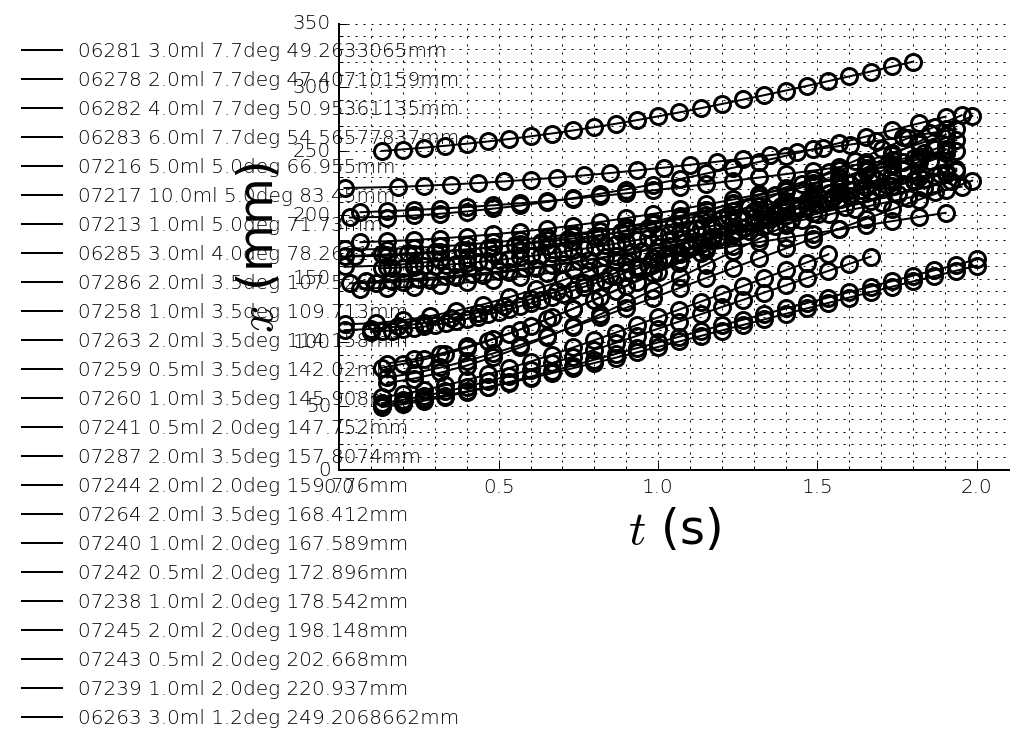

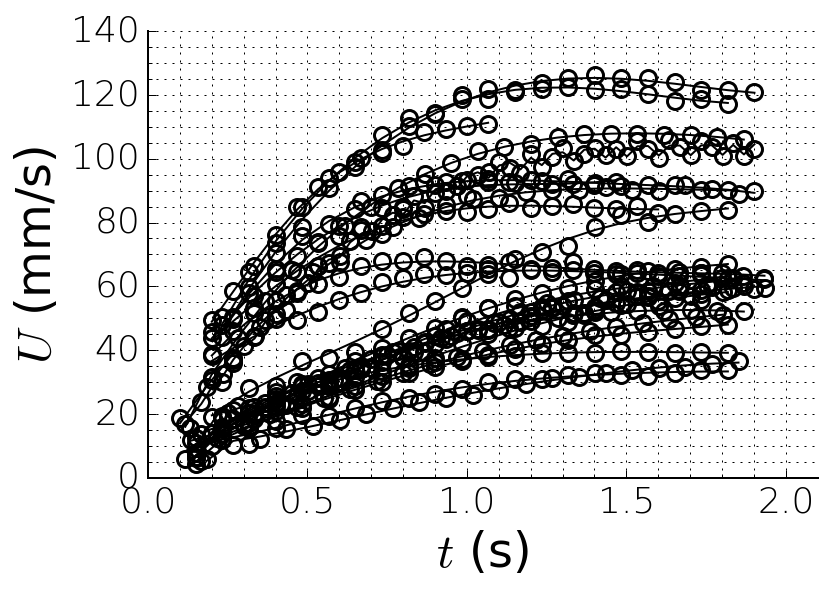

In [70]:
def filtering_data(data,meta,volumes,angles,location):
    fig1 = plt.figure(facecolor="white")
    fig2 = plt.figure(facecolor="white")
    
    v_norm = {}
    x_max = {}
    
    for key in sorted(meta, key = lambda x: meta[x]['ILback']):
        if(meta[key]['Volume'] in volumes and meta[key]['Angle'] in angles):  # checks for called volumes and angles
            dat = data[key][location][1:] 
            t = data[key]['time'][1:]
            if np.size(dat) < 90:
                slice_num = 1
            else:
                slice_num = 5
            dat_sliced = dat[::slice_num]
            t_sliced = t[::slice_num]
            n_sliced = np.size(dat_sliced)
            
            window1 = int(np.floor(n_sliced/2)*2-1)
            window2 = window1-4
            window3 = window2-4

            poly_fit = 5
            x1 = signal.savgol_filter(dat_sliced,window1,poly_fit)
            x2 = signal.savgol_filter(x1,window2,poly_fit)
            dat_filt = signal.savgol_filter(x2,window3,poly_fit)
            
            
            dxdt_savgol = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_savgol[i] = (dat_filt[i+2]-dat_filt[i])/(2*(t_sliced[i+1]-t_sliced[i]))
                
            
            dxdt_centraldiff = np.zeros(np.size(dat_sliced)-2)
            for i in range(np.size(dat_sliced)-2):
                dxdt_centraldiff[i] = (dat_sliced[i+2]-dat_sliced[i])/(2*(t_sliced[i+1]-t_sliced[i]))
            
            x_max[key] = max(dat_sliced)
            v_norm[key] = max(dxdt_centraldiff)
    

            color = 'k'
            style = None
            style2 = 'o'
            ax = fig1.add_subplot(1,1,1)
            # some plot formatting stuff, setting marker colors/types for various volumes
            #if(meta[key]['Volume'] == 0.5):
            #    color = 'k'
            #    style = None
            #elif(meta[key]['Volume'] == 1.0):
            #    color = 'c'
            #    style = None
            #elif(meta[key]['Volume'] == 2.0):
            #    color = 'b'
            #    style = None
            #elif(meta[key]['Volume'] == 5.0):
            #    color = 'r'
            #    style = None
            #elif(meta[key]['Volume'] == 10.0):
            #    color = 'y'
            #    style = None
            #if(meta[key]['Angle'] == 2.0):
            #    style2 = 'o'
            #elif(meta[key]['Angle'] == 3.5):
            #    style2 = 's'
            #elif(meta[key]['Angle'] == 5.0):
            #    style2 = '^'
            dropno = key+' '
            vol = str(meta[key]['Volume'])+'ml '
            angl = str(meta[key]['Angle'])+'deg '
            IL = str( data[key][location][0])+'mm '
            legend_label = dropno+vol+angl+IL
            
            ax.plot(t_sliced,dat_sliced,'.',marker=style2, c = color,fillstyle='none',markeredgewidth=1.5,ms=8)
            ax.plot(t_sliced,dat_filt,c=color,marker=style,linewidth=1,label = legend_label)
            legend1 = basic_plot_format(subplot_label = ax, x_label = '$t$ (s)', y_label = '$x$ (mm)', major_grid = True, minor_grid = True, legend = True)
            ax.set_xlim([0,2.1])        
            ax2 = fig2.add_subplot(1,1,1)
            ax2.plot(t_sliced[1:-1],dxdt_centraldiff,marker=style2,linewidth=0, c = color,fillstyle='none',markeredgewidth=1.5,ms=8)
            ax2.plot(t_sliced[1:-1],dxdt_savgol,c=color,marker=style,linewidth=1,label = legend_label)
            
            legend2 = basic_plot_format(subplot_label = ax2, x_label = '$t$ (s)', y_label = '$U$ (mm/s)', major_grid = True, minor_grid = True, legend = False)
            ax2.set_xlim([0,2.1])
            
    #fig1.savefig('Figures/positions.png',dpi=100,bbox_extra_artists=(legend1,), bbox_inches='tight')
    #fig2.savefig('Figures/velocities.png',dpi=100, bbox_inches='tight')
    return v_norm, x_max

[v_norm, x_max ] = filtering_data(data,meta,volumes,angles,location)
plt.show()

# Normalized stuff

The data can be better described through a non-dimensional plot of max velocity versus the capillary confinement parameter.

In [71]:
def normalized_variables(meta,data,location):
    xi_norm = {}
    for key in sorted(data):
        xi = data[key][location][0]/1000 # m
        V = meta[key]['Volume']*(10**(-6)) # m^3
        alpha = (meta[key]['Angle']/2.)*(math.pi/180.) # rad
        xi_norm[key] = xi*((4*math.pi)/(3*V))**(1/3.)*math.sin(alpha)
        
    return xi_norm  

xi_norm = normalized_variables(meta,data,location)
   

# Linear fit to data

Looks like theres a linear trend of velocity wrt the capillary confinement parameter, linear regression looks nice.

In [72]:
xi_vector = np.zeros(n_files)
v_vector = np.zeros(n_files)
i = int(0)
for key in xi_norm:
    xi_vector[i] = xi_norm[key]
    v_vector[i] = v_norm[key]
    i=i+1  
fit = np.polyfit(xi_vector,v_vector,1)
fit_fn = np.poly1d(fit)


# Non-dimenionalized plot: $U_{max}^*$ vs $x_i^*$

/home/logan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


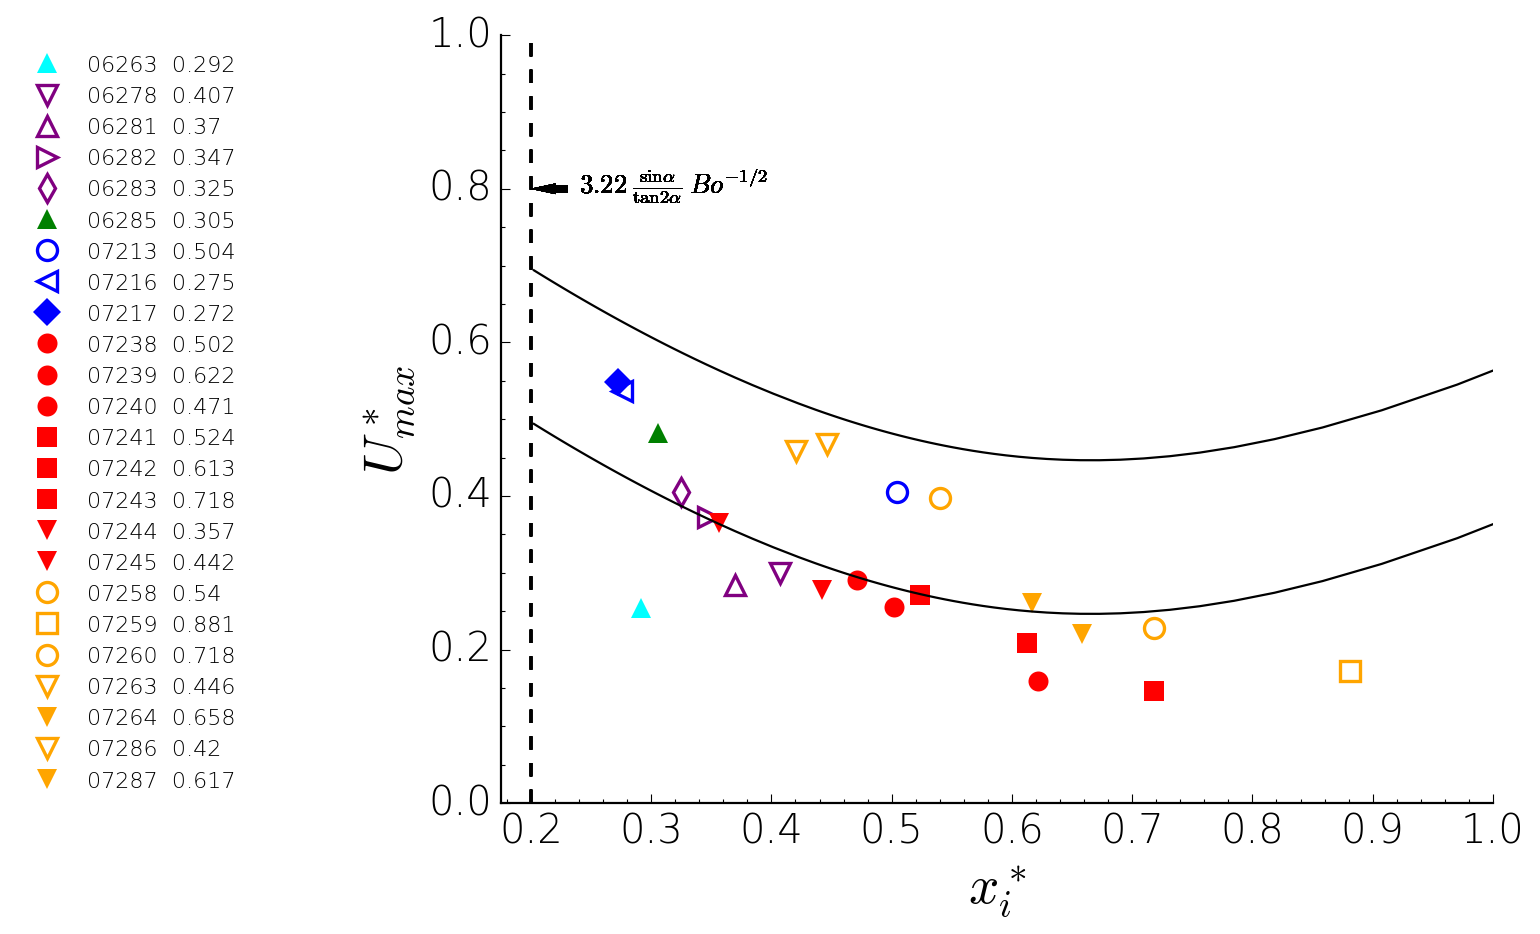

In [315]:
from matplotlib.lines import Line2D
v_max = ((4*0.072*9.81)/1000)**(1/4.)*1000
fig1 = plt.figure(facecolor="white")
n_angles= np.size(angles)
colormap = plt.get_cmap('Accent')
cNorm  = colors.Normalize(vmin=0, vmax=n_angles-1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=colormap)

for key in xi_norm:
    R = ((3000*meta[key]['Volume'])/(4*math.pi))**(1/3)
    sin_angl = math.sin((meta[key]['Angle']/2)*(math.pi/180))
    x_max_theo = (R/sin_angl)
    
    if x_max[key]>x_max_theo:
        fill = 'none'
        w = 1.5
      
    elif x_max[key]<=x_max_theo:
        fill = 'full'
        w=0
    
    
    
    if meta[key]['Angle']== 2.0:
        clr = 'red'
    elif meta[key]['Angle']== 1.2:
        clr = 'cyan'
    elif meta[key]['Angle']== 3.5:
        clr = 'orange'
    elif meta[key]['Angle']== 4.0:
        clr = 'green'
    elif meta[key]['Angle']== 5.0:
        clr = 'blue'
    elif meta[key]['Angle']== 7.7:
        clr = 'purple'
        
    if meta[key]['Volume']== 0.5:
        style = 's'
    elif meta[key]['Volume']== 1.0:
        style = 'o'
    elif meta[key]['Volume']== 2.0:
        style = 'v'
    elif meta[key]['Volume']== 3.0:
        style = '^'
    elif meta[key]['Volume']== 4.0:
        style = '>'
    elif meta[key]['Volume']== 5.0:
        style = '<'
    elif meta[key]['Volume']== 6.0:
        style = 'd'
    elif meta[key]['Volume']== 10.0:
        style = 'D'    

    ax = fig1.add_subplot(1,1,1) 
    dropno = key+' '
    vol = str(meta[key]['Volume'])+'ml '
    angl = str(meta[key]['Angle'])+'deg '
    IL = str( data[key][location][0])+'mm '
    xii = ' '+str(np.round(xi_norm[key],3))
    legend_label = dropno+xii
    
    ax.plot(xi_norm[key],v_norm[key]/v_max,\
                marker=style,\
                c = clr,\
                ms=9,\
                fillStyle=fill,\
                markeredgewidth=w,\
                label = legend_label,\
                linestyle = 'none'
           )
    #ax.plot(xi_vector,fit_fn(xi_vector)/v_max,'k')
    ax.plot([0.2,0.2],[0,1],c='k',linestyle='--')
    legend1 = basic_plot_format(subplot_label = ax, \
                      x_label = '$x_i^*$',  \
                      y_label = '$U_{max}^*$', \
                      major_grid = False,  \
                      minor_grid = False,  \
                      legend = True
                     )
    ax.arrow(0.2275, 0.80, -0.01, 0,linewidth=3)
    ax.text(0.24,0.795,r'$ 3.22\hspace{.25}\frac{\sin\alpha}{\tan2\alpha}\hspace{.25} Bo^{-1/2}$ ',fontsize=12,weight=0)
    #v_label_x = 0.6+0.5
    #text_offset = 0.03
    #ax.text(v_label_x+text_offset, 0.69, '0.5 mL', fontsize=14,weight=0)
    #ax.plot([v_label_x],[0.7],'^',c='k',ms=8,markeredgewidth=0)
    
    #ax.text(v_label_x+text_offset, 0.64, '1.0', fontsize=14,weight=0)
    #ax.plot([v_label_x],[0.65],'s',c='k',ms=8,markeredgewidth=0)
    
    #ax.text(v_label_x+text_offset, 0.59, '2.0', fontsize=14,weight=0)
    #ax.plot([v_label_x],[0.6],'o',c='k',ms=8,markeredgewidth=0)
    
    #ax.text(v_label_x+text_offset, 0.54, '5.0', fontsize=14,weight=0)
    #ax.plot([v_label_x],[0.55],'p',c='k',ms=9,markeredgewidth=0)
    
    #ax.text(v_label_x+text_offset, 0.49, '10.0', fontsize=14,weight=0)
    #ax.plot([v_label_x],[0.5],'D',c='k',ms=7,markeredgewidth=0)
    
    #v_label_x_color = 0.75+0.5
    #text_offset = 0.06
    #ax.text(v_label_x_color, 0.69, r'$\alpha$ $=$', fontsize=14,color='k',weight=0)
    #ax.text(v_label_x_color+text_offset, 0.69, r'1.0$^{\circ}$', fontsize=14,color='navy',weight=0)
    
    #ax.text(v_label_x_color+text_offset, 0.64, r'1.75$^{\circ}$', fontsize=14,color='b',weight=0)
    
    #ax.text(v_label_x_color+text_offset, 0.59, r'2.5$^{\circ}$', fontsize=14,color='r',weight=0)

    ax.set_xlim([0.175,1])
    ax.set_ylim([0,1])
Vtheotest1 = np.linspace(0.01,1)
Vtheotest2 = np.linspace(1.1,10)    
Vtheo = np.append(Vtheotest1,Vtheotest2)
Hcap = 2*(0.072/(1000*9.81))**(1/2)*1000
term1 = -2*math.cos(150*(math.pi/180))
term2 = 2*((math.pi*Hcap**3)/(Vtheo*1000))**(1/2)
term3 = -6**(2/3)*((math.pi*Hcap**3)/(Vtheo*1000))**(1/3)
Utheo = (0.072*9.81/1000)**(1/4)*(term1+term2+term3)**(1/2)
Vtheocub = [3.22*0.5*(0.072/(1000*9.81*(element*10**-6)**(2/3)))**(1/2) for element in Vtheo]
ax.plot(Vtheocub,Utheo*(1000/v_max),'k')
ax.plot(Vtheocub,Utheo*(1000/v_max)-0.2,'k')
#plt.gca().invert_xaxis()
fig1.savefig('Figures/dimensionalplot.png',dpi=400, bbox_inches='tight')
plt.show()

Red = $5.0^o$ $\hspace{35pt}$ Triangle = $0.5$mL

Blue = $3.5^o$  $\hspace{34pt}$ Square = $1.0$mL

light Blue = $2.0^o$  $\hspace{17pt}$ Circle = $2.0$mL

$\hspace{73pt}$ Diamond = $10.0$mL



linear trend of max velocity? capillary confinement parameter $x_i^* = x_i \sin\alpha(\frac{4 \pi}{3 V})^{1/3}  $ where $x_i$ is the initial location of the droplet relative to the wedge vertex, $V$ is the droplet volume, and $\alpha$ is the wedge half angle. $U_{limit}$ is found by thermodynamic principles of conservation of energy: access of surface energy associated with unconfined state compare to the initial state is assumed to be completely transferred to kinetic energy (alternative description, capillary pressure gradients associated with surface curvatures). Under limits of large volume small angle experiments, a theoretical velocity is found to be $U_{limit} = (\frac{4 \sigma g}{\rho})^{1/4}$. 

Energy model dependent on volume can be computed. Shown below. Not linear, hm.

# Exit times

/home/logan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


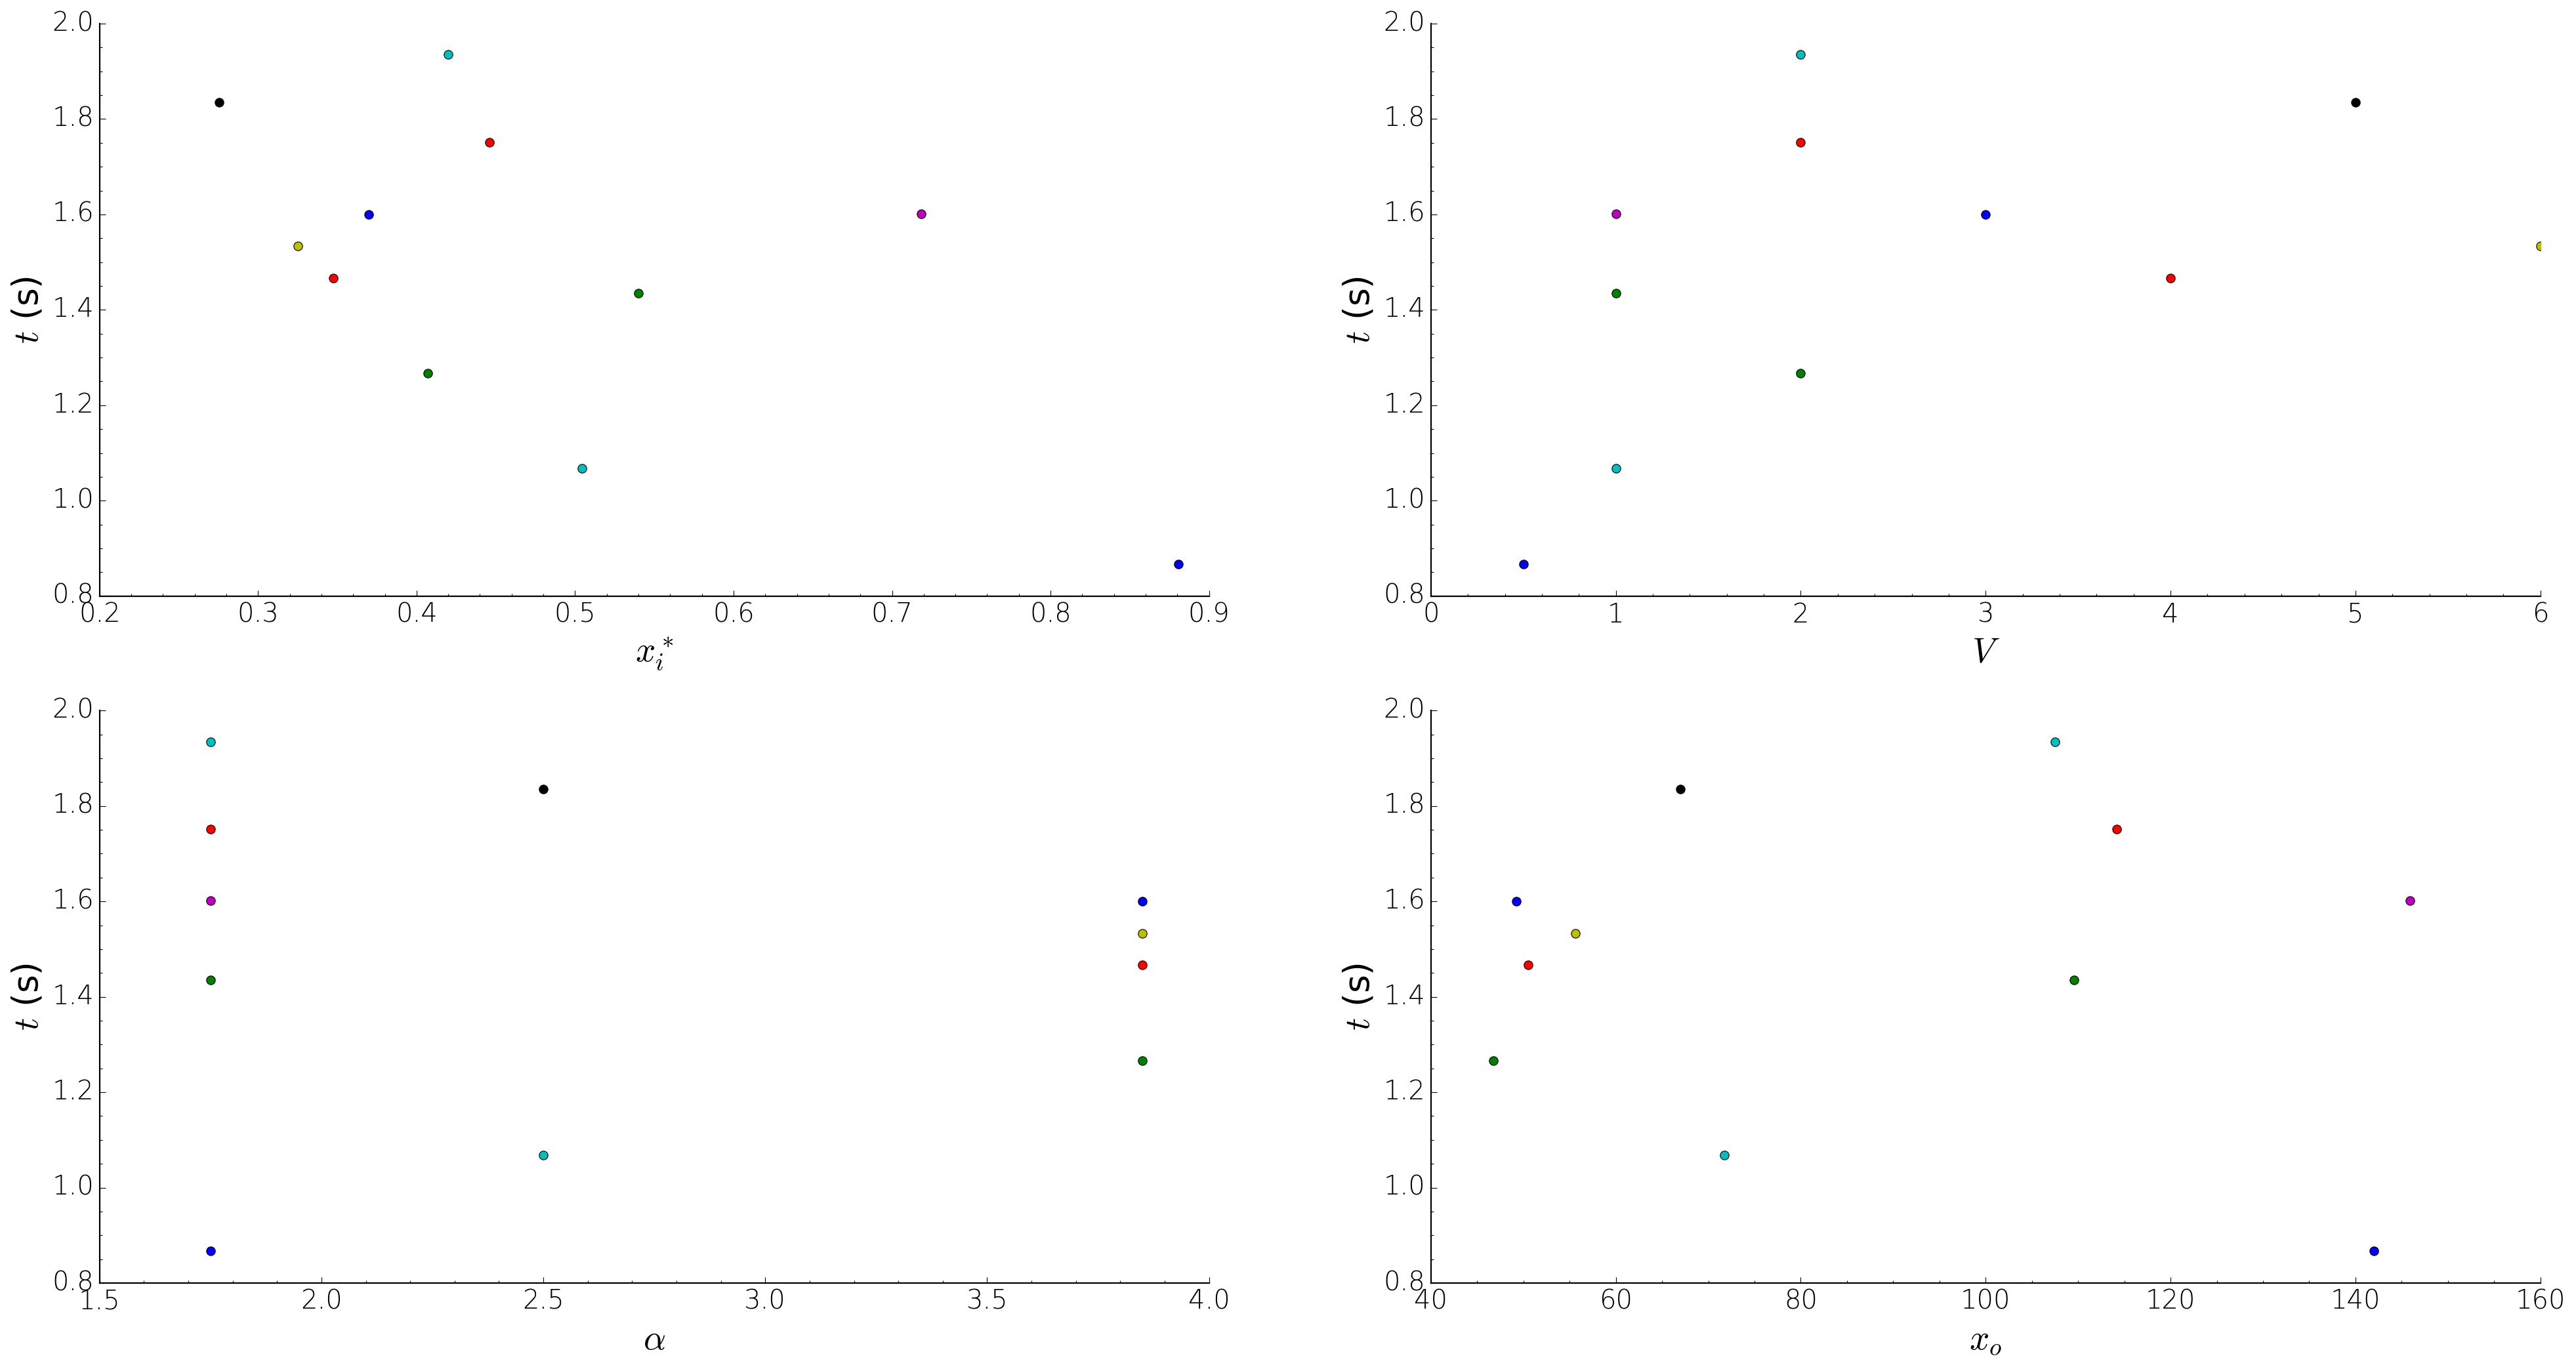

In [278]:
def exit_time_plots(data,meta):
    exit_times = {}
    distance2exit = {}
    for key in data:
        R = ((3000*meta[key]['Volume'])/(4*math.pi))**(1/3)
        sin_angl = math.sin((meta[key]['Angle']/2)*(math.pi/180))
        x_max_theo = (R/sin_angl)

        if np.max(data[key]['average'])>x_max_theo:
            i = np.min(np.where(data[key]['average']>=x_max_theo))
            exit_times[key] = data[key]['time'][i]

        else:
            distance2exit[key] = x_max_theo-np.max(data[key]['average'])
    fig = plt.figure(facecolor='white')
    fig.set_figheight(15)
    fig.set_figwidth(30)
    for key in exit_times:
        
        ax = fig.add_subplot(2,2,1)
        ax.plot(xi_norm[key],exit_times[key],'o')
        legend = basic_plot_format(ax,r'$x_i^*$',r'$t$ (s)',False,False,False)
        ax = fig.add_subplot(2,2,2)
        ax.plot(meta[key]['Volume'],exit_times[key],'o')
        legend = basic_plot_format(ax,r'$V$',r'$t$ (s)',False,False,False)
        ax = fig.add_subplot(2,2,3)
        ax.plot(meta[key]['Angle']/2,exit_times[key],'o')
        legend = basic_plot_format(ax,r'$\alpha$',r'$t$ (s)',False,False,False)
        ax = fig.add_subplot(2,2,4)
        ax.plot(meta[key]['IL'],exit_times[key],'o')
        legend = basic_plot_format(ax,r'$x_o$',r'$t$ (s)',False,False,False)
    plt.show()
exit_time_plots(data,meta)

/home/logan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


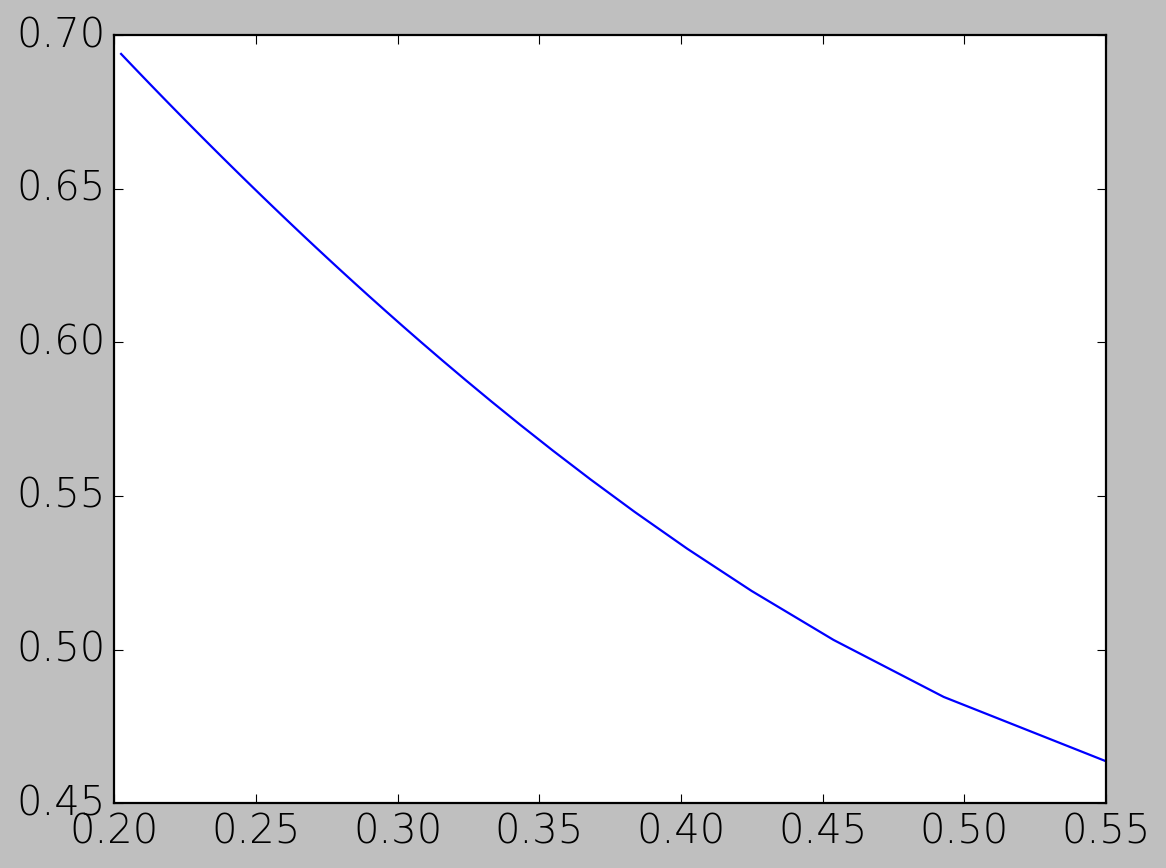

In [27]:
Vtheo = np.linspace(0.5,10)
Hcap = 2*(0.072/(1000*9.81))**(1/2)*1000
term1 = -2*math.cos(150*(math.pi/180))
term2 = 2*((math.pi*Hcap**3)/(Vtheo*1000))**(1/2)
term3 = -6**(2/3)*((math.pi*Hcap**3)/(Vtheo*1000))**(1/3)
Utheo = (0.072*9.81/1000)**(1/4)*(term1+term2+term3)**(1/2)
Vtheocub = [3.22*0.5*(0.072/(1000*9.81*(element*10**-6)**(2/3)))**(1/2) for element in Vtheo]
plt.plot(Vtheocub,Utheo*(1000/v_max))
#plt.gca().invert_xaxis()
plt.show()

In [20]:
 def image_angle_calculator(dir_path,n_files,meta,data):
    RAW_filesb = os.path.join(dir_path,'RAW_Spotlight','*back.txt')
    RAW_filesf = os.path.join(dir_path,'RAW_Spotlight','*front.txt')
    RAW_back = glob.glob(RAW_filesb)
    RAW_front = glob.glob(RAW_filesf)

    center = {}
    for key in sorted(meta):
        center[key] = meta[key]['Center']

    xraw = {}
    for i in range(n_files):
        key = RAW_back[i].split('\\')[6][:5]
        fback = open(RAW_back[i],"r")
        ffront = open(RAW_front[i],"r")
        fb = fback.readlines()
        ff = ffront.readlines()
        nb = np.size(fb[9:])
        nf = np.size(ff[9:])
        xraw_arrayb = np.zeros(nb)
        xraw_arrayf = np.zeros(nf)
        for i in range(nb):
            j = i + 9
            xraw_arrayb[i] = float(fb[j].split()[3])
        for i in range(nf):
            j = i + 9
            xraw_arrayf[i] = float(ff[j].split()[3])
        xraw[key] = (xraw_arrayb+xraw_arrayf)*0.5
        fback.close()
        ffront.close()

    gamma = {}
    for key in meta:
        dxcenter = xraw[key]-center[key]
        gamma[key] = np.zeros(np.size(dxcenter))
        for i in range(np.size(dxcenter)):
            if dxcenter[i]>0:
                # if to right of center its a negative angle
                gamma[key][i] = -np.arctan(abs(dxcenter[i])/285)
            else:
                # if to left of center its a positive angle
                gamma[key][i] = np.arctan(abs(dxcenter[i])/285)
        
    return gamma

#gamma = image_angle_calculator(dir_path,n_files,meta,data)
#plt.plot(data['07240']['time'][:-1],gamma['07240'])
#plt.xlabel('t (s)')
#plt.ylabel(r'$\gamma$ ($^{\circ}$)')
#plt.title('Angle relative to image midline')

# $D$ vs $x$ (approx)

In [280]:
from sympy import *

diameter = {}
xave_theo = {}

for key in sorted(meta):
    V = meta[key]['Volume']*1000
    Rv = ((3*V)/(4*math.pi))**(1/3)
    
    alpha = (meta[key]['Angle']/2)*(math.pi/180)
    thetaf = 180*(math.pi/180)
    thetab = 180*(math.pi/180)

    gammaf = thetaf - alpha - (math.pi/2)
    gammab = thetab + alpha - (math.pi/2)

    beta1f = (2*gammaf - math.sin(2*gammaf))/(2*(math.sin(gammaf)**2))
    beta1b = (2*gammab - math.sin(2*gammab))/(2*(math.sin(gammab)**2))
    beta2f = ((2./3) - (beta1f/math.tan(gammaf)))
    beta2b = ((2./3) - (beta1b/math.tan(gammab)))
    
    
    xs = np.linspace(5.4/math.tan(2*alpha),Rv/math.sin(alpha),25)
    xave_theo[key] = np.zeros(np.size(xs))
    eqs = np.zeros(np.size(xs))
    for i in range(np.size(xs)):
        x = xs[i]
        r = Symbol('r')
        term0 = math.pi*r*(math.tan(alpha)**2)
        term1 = (math.tan(alpha)/r)*(((x-r)**3)*beta2f + ((x+r)**3)*beta2b)
        term2 = (((x-r)**2)*beta1f + ((x+r)**2)*beta1b)
        term3 = 2*math.pi*(r**2)*x*math.tan(alpha)
        eq = (term0*(term1+term2))+term3 - V

        eq_solved = solve(eq,r)
        rr = re(eq_solved[2])
        hb = (((x-rr)*math.tan(alpha))/math.sin(gammab))*(1-math.cos(gammab))
        hf = (((x+rr)*math.tan(alpha))/math.sin(gammaf))*(1-math.cos(gammaf))
        eqs[i] = (2*rr)+hb+hf
        xave_theo[key][i] = ((x-rr-hb)+(x+rr+hf))/2
    diameter[key] = eqs
    print(key+': done')
print('Finished')

06263: done
06278: done
06281: done
06282: done
06283: done
06285: done
07213: done
07216: done
07217: done
07238: done
07239: done
07240: done
07241: done
07242: done
07243: done
07244: done
07245: done
07258: done
07259: done
07260: done
07263: done
07264: done
07286: done
07287: done
Finished


In [281]:
def prop_error(meta,data):
    error_diameter = {}
    error_x = {}
    for key in meta:
        V = meta[key]['Volume']
        alpha = (meta[key]['Angle']/2)*math.pi/180
        dd = np.array(data[key]['front']-data[key]['back'])
        
        error_x[key] = 1*meta[key]['Scale'] #pxl
        errorx = 1*meta[key]['Scale'] #pxl
        errorV = 0.1 #mL
        errorAlpha = 0.001*math.pi/180  #rad
        #errord = np.array( np.sqrt(\
        #                              (errorV/(2*V))**2 + \
        #                              ( (math.tan(alpha)*errorAlpha)/(-math.sin(alpha)**2) )**2 + \
        #                              (errorx/dd)**2 \
        #                             )\
        #                  )
        errord = math.sqrt(\
                        (errorV/(2*V))**2 + \
                        ( (math.tan(alpha)*errorAlpha)/(-math.sin(alpha)**2) )**2 \
                        )
                          
        error_diameter[key] = errord
    
    return error_diameter,error_x
error_diameter,error_x = prop_error(meta,data)

/home/logan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


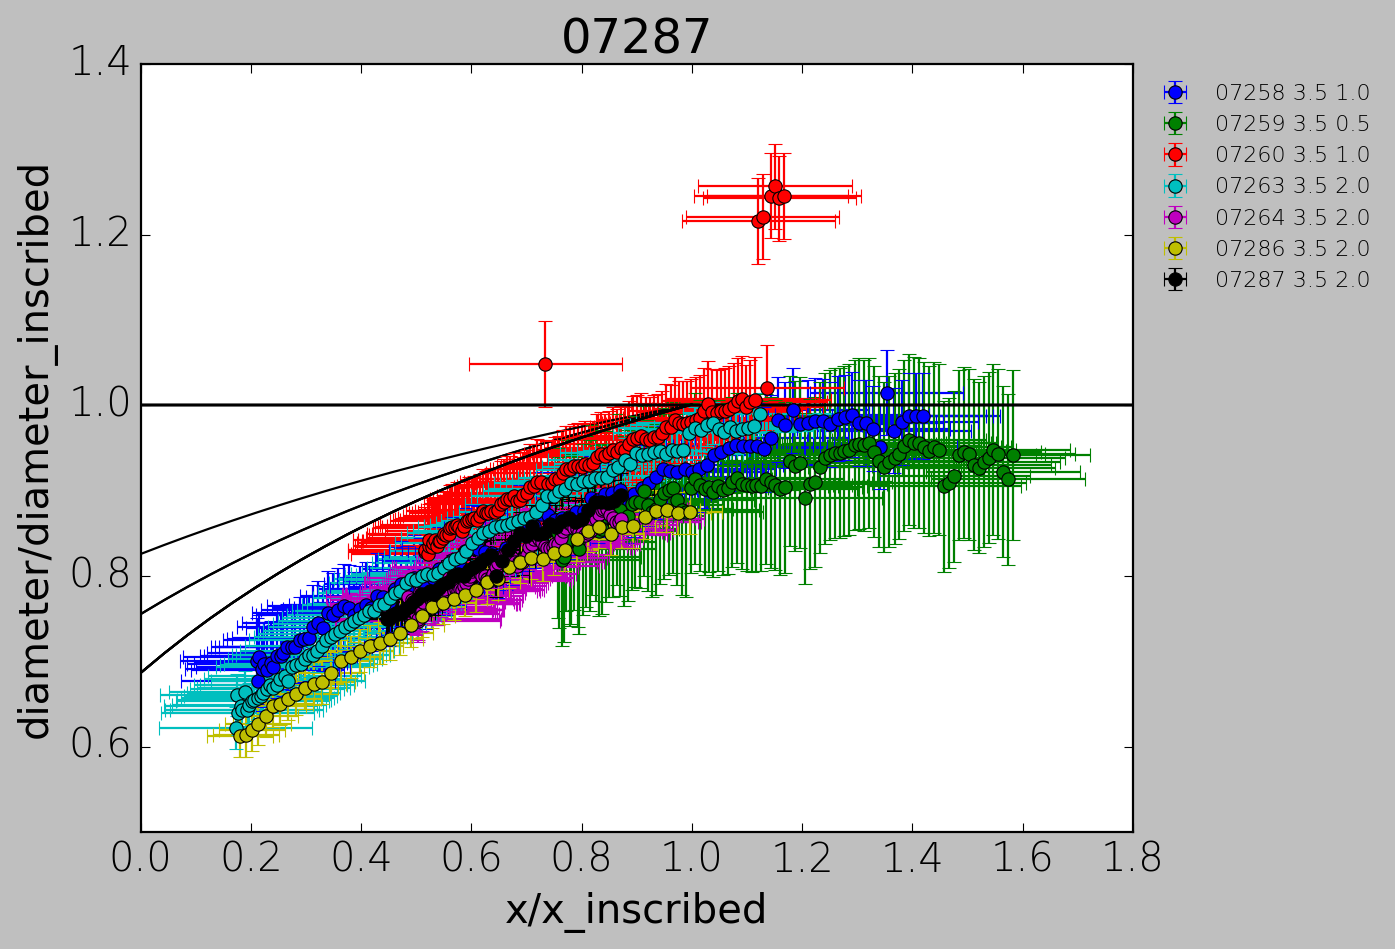

In [290]:
def plot_diameter(data,meta,error_diameter,error_x):
    for key in sorted(meta):
        if meta[key]['Angle'] == 3.5:
            V = meta[key]['Volume']
            alpha = (meta[key]['Angle']/2)*(math.pi/180)
            d_exit = ((3000*V)/(4*math.pi))**(1/3)*2
            x_start = 5.4/math.tan(2*alpha)
            x_inscribed = (d_exit/2)/math.tan(alpha)
            #print(str(V)+' '+str(alpha)+' '+str(d_exit))
            back = data[key]['back']
            front = data[key]['front']
            xave = data[key]['average']

            diameter_exp = front-back
            n = np.size(diameter_exp[1:-1])
            ws1 = int(np.floor(n/2)*2-1)
            ws2 = ws1-2
            ws3 = int(np.floor((ws2/2)/2)*2-1)
            ws4 = int(np.floor((ws3/2)/2)*2-1)
            d_filt4 = signal.savgol_filter(diameter_exp[1:-1],ws1,3)
            #d_filt2 = signal.savgol_filter(d_filt1,ws2,3)
            #d_filt3 = signal.savgol_filter(d_filt2,ws3,3)
            #d_filt4 = signal.savgol_filter(d_filt3,ws3,3)
            
            
            x_norm_theo = (xave_theo[key]-x_start)/(x_inscribed-x_start)
            d_norm_theo = d_exit/diameter[key]
            x_norm_exp = (data[key]['average'][10:-1]-x_start)/(x_inscribed-x_start)
            d_norm_exp = d_exit/diameter_exp[10:-1]
            plt.axhline(1,c='k')
            label = key + ' ' +str(meta[key]['Angle']) + ' ' + str(meta[key]['Volume'])
            plt.plot(x_norm_theo, d_norm_theo,c='k')
            plt.errorbar(x_norm_exp[::1], d_norm_exp[::1], yerr=error_diameter[key],xerr=error_x[key],\
                        fmt='o',label = label)
            plt.legend(numpoints = 1,bbox_to_anchor=(1, 1),loc='upper left',frameon=False,fontsize=10)
            plt.title(key)
            plt.xlabel('x/x_inscribed')
            plt.ylabel('diameter/diameter_inscribed')
            
            
            
        else:
            diameter_exp = 0
   
    plt.show()
plot_diameter(data,meta,error_diameter,error_x)